In [68]:
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [77]:
import pandas as pd

# Direct download URL for the Google Drive file
CSV_URL = 'https://drive.google.com/uc?export=download&id=1iyhG9KK2SpLS1BxP6axyTMZw7RMjWgwR'

try:
    # Read the CSV file directly into a DataFrame
    rent_apartments_dataset = pd.read_csv(CSV_URL)
except Exception as e:
    print("Error reading the CSV file:", e)

### Understanding Data Structure and Content

In [3]:
print(rent_apartments_dataset.head(10))

   bathrooms  bedrooms     price  square_feet  latitude  longitude  \
0  -0.618665 -1.856313 -0.072764    -1.898721   38.8910   -77.0816   
1  -0.618665 -1.856313 -0.729211    -1.877790   47.6160  -122.3275   
2  -0.618665 -1.856313  1.458945    -1.845231   40.7629   -73.9885   
3  -0.618665 -1.856313  0.075465    -1.826626   37.7599  -122.4379   
4  -0.618665 -1.856313  0.357808    -1.705692   37.7599  -122.4379   
5  -0.618665 -0.794153  0.167227    -1.682436   35.0847   -77.0609   
6  -0.618665 -0.794153  0.167227    -1.682436   35.0960   -77.0272   
7  -0.618665 -0.794153 -0.623333    -1.682436   30.0871   -95.4685   
8  -0.618665 -0.794153 -0.693918    -1.682436   38.1172  -122.2313   
9  -0.618665 -0.794153 -1.152725    -1.682436   33.9649   -84.5107   

           time  amenity_parking  amenity_dishwasher  amenity_pool  ...  \
0  1.577359e+09                0                   0             0  ...   
1  1.576668e+09                0                   0             0  ...   
2  1

In [58]:
df = pd.read_csv(CSV_URL)

## Decision Tree Regressor with Pre-Pruning, Post-Pruning, and Regularization



Pre-Pruning - Mean Squared Error (MSE): 0.4621238266607109
Pre-Pruning - R-squared (R²): 0.5352579795017046
Pre-Pruning - Mean Absolute Error (MAE): 0.5048842967933254


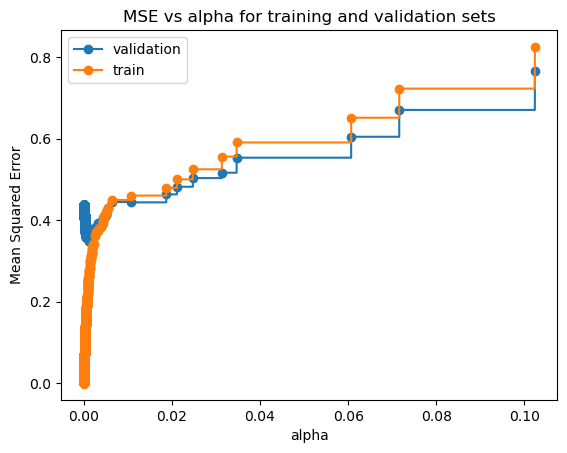

Best ccp_alpha based on validation set: 0.0012281220967517812
Mean Squared Error on train data after pruning:  0.27424425877315417
Mean Squared Error on the test data after pruning:  0.33190891998521577
R-squared on the test data after pruning:  0.6662106275498594
Mean Absolute Error on the test data after pruning:  0.4180181558807021
Regularized Tree - Mean Squared Error (MSE): 0.4621238266607108
Regularized Tree - R-squared (R²): 0.5352579795017047
Regularized Tree - Mean Absolute Error (MAE): 0.5048842967933256


In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Scale latitude, longitude, and time
scaler = StandardScaler()
df[['latitude', 'longitude', 'time']] = scaler.fit_transform(df[['latitude', 'longitude', 'time']])

X = df.drop(['price'], axis=1)  # Features
y = df['price']  # Target

# Split the dataset into training (75%), validation (25% of train), and testing sets (25%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=0)

### 1. Pre-Pruning (Early Stopping) ###

##Pre-pruning parameters such as max_depth, min_samples_split, min_samples_leaf, and min_impurity_decrease are set to limit the growth of the tree##

pre_pruned_tree = DecisionTreeRegressor(
    random_state=42,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    min_impurity_decrease=0.01
)
pre_pruned_tree.fit(X_train, y_train)
y_test_pred = pre_pruned_tree.predict(X_test)

mse_pre_pruned = mean_squared_error(y_test, y_test_pred)
r2_pre_pruned = r2_score(y_test, y_test_pred)
mae_pre_pruned = mean_absolute_error(y_test, y_test_pred)

print(f"Pre-Pruning - Mean Squared Error (MSE): {mse_pre_pruned}")
print(f"Pre-Pruning - R-squared (R²): {r2_pre_pruned}")
print(f"Pre-Pruning - Mean Absolute Error (MAE): {mae_pre_pruned}")

### 2. Post-Pruning (Reduced Error Pruning) ###
## The full tree is grown first, and then cost complexity pruning is applied using ccp_alpha ##


# Grow the full tree
full_tree = DecisionTreeRegressor(random_state=42)
full_tree.fit(X_train, y_train)

# Perform cost complexity pruning to simulate post-pruning
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Filter out invalid ccp_alpha values
ccp_alphas = ccp_alphas[ccp_alphas >= 0]

# Train trees with different values of ccp_alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

val_scores = [mean_squared_error(y_val, clf.predict(X_val)) for clf in clfs]
train_scores = [mean_squared_error(y_train, clf.predict(X_train)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Mean Squared Error")
ax.set_title("MSE vs alpha for training and validation sets")
ax.plot(ccp_alphas, val_scores, marker='o', label="validation", drawstyle="steps-post")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.legend()
plt.show()

# Selecting the best alpha based on validation set performance
best_index = np.argmin(val_scores)
best_alpha = ccp_alphas[best_index]
best_pruned_tree = clfs[best_index]

print(f"Best ccp_alpha based on validation set: {best_alpha}")

# Initialize and train the pruned tree with the best alpha value
clf_pruned = DecisionTreeRegressor(random_state=0, ccp_alpha=best_alpha).fit(X_train, y_train)
# plot_tree(clf_pruned, filled=True)
# plt.show()

# Evaluate the pruned model on the training and test sets
print('Mean Squared Error on train data after pruning: ', mean_squared_error(y_true=y_train, y_pred=clf_pruned.predict(X_train)))
print('Mean Squared Error on the test data after pruning: ', mean_squared_error(y_true=y_test, y_pred=clf_pruned.predict(X_test)))
print('R-squared on the test data after pruning: ', r2_score(y_true=y_test, y_pred=clf_pruned.predict(X_test)))
print('Mean Absolute Error on the test data after pruning: ', mean_absolute_error(y_true=y_test, y_pred=clf_pruned.predict(X_test)))

### 3. Regularization Parameters ###
## Additional regularization parameters like max_leaf_nodes are set to further control the complexity of the tree##

regularized_tree = DecisionTreeRegressor(
    random_state=42,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_leaf_nodes=20,
    min_impurity_decrease=0.01
)
regularized_tree.fit(X_train, y_train)
y_test_pred = regularized_tree.predict(X_test)

mse_regularized = mean_squared_error(y_test, y_test_pred)
r2_regularized = r2_score(y_test, y_test_pred)
mae_regularized = mean_absolute_error(y_test, y_test_pred)

print(f"Regularized Tree - Mean Squared Error (MSE): {mse_regularized}")
print(f"Regularized Tree - R-squared (R²): {r2_regularized}")
print(f"Regularized Tree - Mean Absolute Error (MAE): {mae_regularized}")


## Additional Strategies for Decision Tree Improvement


## Hyperparameter Tuning:

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. T

Best parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 20}


/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


In [80]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Create the Decision Tree Regressor with the best parameters
best_regressor = DecisionTreeRegressor(max_depth=20, 
                                       max_features='auto', 
                                       min_samples_leaf=5, 
                                       min_samples_split=20, 
                                       random_state=42)

# Train the model using the training data
best_regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = best_regressor.predict(X_test)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 0.3240121791006033
R-squared (R²): 0.6741521079547657
Mean Absolute Error (MAE): 0.40238392344879553


/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(



## Grid Search with K-Fold Cross-Validation

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid more granularly
param_grid = {
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20, 30],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_leaf_nodes': [None, 10, 20, 30, 40],
    'min_impurity_decrease': [0.0, 0.0001, 0.001, 0.01],
    'max_features': ['sqrt', 'log2', None]
}

# Perform GridSearchCV to find the best parameters with K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters for Decision Tree:", grid_search.best_params_)

# Use the best parameters to initialize the Decision Tree Regressor
best_regressor = grid_search.best_estimator_

# Perform 10-fold cross-validation on the entire dataset with the best parameters
cv_scores = cross_val_score(best_regressor, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_scores = -cv_scores

# Calculate mean and standard deviation of the cross-validated MSE
mean_cv_mse = np.mean(cv_scores)
std_cv_mse = np.std(cv_scores)

print(f"10-fold Cross-validated Mean Squared Error (MSE): {mean_cv_mse}")
print(f"10-fold Cross-validated Standard Deviation of MSE: {std_cv_mse}")

# Train the model using the entire training set with best parameters
best_regressor.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = best_regressor.predict(X_test)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test Set Mean Squared Error (MSE): {mse}")
print(f"Test Set R-squared (R²): {r2}")
print(f"Test Set Mean Absolute Error (MAE): {mae}")


Best parameters for Decision Tree: {'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 6, 'min_samples_split': 2}
10-fold Cross-validated Mean Squared Error (MSE): 0.31389028573177846
10-fold Cross-validated Standard Deviation of MSE: 0.018989881478826878
Test Set Mean Squared Error (MSE): 0.32511216699804374
Test Set R-squared (R²): 0.6735483975868197
Test Set Mean Absolute Error (MAE): 0.39094665719640226


## COMPARISON OF RESULTS

### Regression Model Performance Comparison

| Metric/Model           | Pre-Pruning | Post-Pruning | Regularization | GridSearchCV | 10-Fold CV  |
|------------------------|-------------|--------------|----------------|--------------|-------------|
| Mean Squared Error (MSE)| 0.4621      | 0.3319       | 0.4621         | 0.3240       | 0.3251      |
| R-squared (R²)         | 0.5353      | 0.6662       | 0.5353         | 0.6742       | 0.6735      |
| Mean Absolute Error (MAE)| 0.5049    | 0.4180       | 0.5049         | 0.4024       | 0.3909      |


## Analysis:


#### Pre-Pruning and Regularization both result in higher MSE and lower R² compared to other methods, indicating that these approaches are less effective for this dataset.

#### Post-Pruning shows a significant improvement over Pre-Pruning and Regularization with lower MSE and higher R², indicating better performance. The MAE also decreases, suggesting better predictive accuracy.

#### GridSearchCV achieves the best performance overall with the lowest MSE (0.3240) and the highest R² (0.6742), indicating that the model explains the most variance in the data. The MAE is also relatively low at 0.4024.

#### 10-Fold Cross-Validation also shows excellent performance, with very close MSE (0.3251) and R² (0.6735) values to those obtained from GridSearchCV. It also has the lowest MAE (0.3909), which suggests that it provides the most accurate predictions on average.

## Conclusion:

#### The GridSearchCV method provides the best overall performance based on MSE and R², indicating that it produces the most accurate and reliable model for this dataset. The 10-Fold Cross-Validation method also performs very well, with slightly higher MSE but the lowest MAE, making it a strong contender.

#### Based on these results, GridSearchCV can be considered the best method for tuning the Decision Tree Regressor for this dataset, closely followed by 10-Fold Cross-Validation.

## Adult Dataset

In [93]:
# Direct download URL for the Google Drive file
CSV_URL = 'https://drive.google.com/uc?export=download&id=1K2zmMuv0mj-vTdVmL7skUD_uFND0gg0U'

try:
    # Read the CSV file directly into a DataFrame
    adult_dataset = pd.read_csv(CSV_URL)
except Exception as e:
    print("Error reading the CSV file:", e)

In [94]:
df1 = pd.read_csv(CSV_URL)

### Understanding Data Structure and Content

In [95]:
df1.info

<bound method DataFrame.info of        age  fnlwgt  education-num  sex  capital-gain  capital-loss  \
0       22  231912             11    0             0             0   
1       79  165209              9    1             0             0   
2       43   47818             13    0             0             0   
3       29  565769              1    1             0             0   
4       57  222216             11    0             0             0   
...    ...     ...            ...  ...           ...           ...   
23369   38  149347             14    1             0             0   
23370   43   23157             14    1             0          1902   
23371   40  202168             15    1         15024             0   
23372   50  139347             14    0             0             0   
23373   35  182148             13    1             0             0   

       hours-per-week  native-country  income  workclass_Other  ...  \
0                  37              39       0           

In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


df1 = pd.read_csv(CSV_URL)

# Scale the 'fnlwgt' column
scaler = StandardScaler()
df1['fnlwgt'] = scaler.fit_transform(df[['fnlwgt']])

X = df.drop(['income'], axis=1)  # Features
y = df['income']  # Target


# Split the dataset into training (75%), validation (25% of train), and testing sets (25%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=0)

## Decision Tree Classifier with Pre-Pruning, Post-Pruning, and Regularization

Pre-Pruning - Accuracy: 0.7864476386036962
Pre-Pruning - Confusion Matrix:
 [[1984  960]
 [ 288 2612]]
Pre-Pruning - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.67      0.76      2944
           1       0.73      0.90      0.81      2900

    accuracy                           0.79      5844
   macro avg       0.80      0.79      0.78      5844
weighted avg       0.80      0.79      0.78      5844



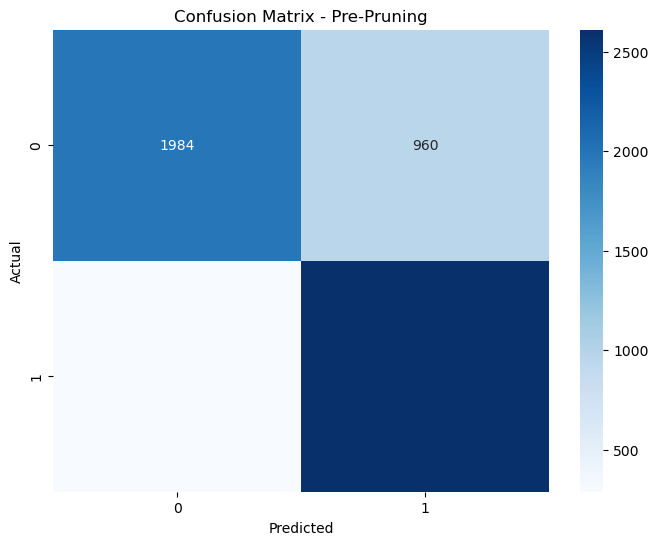

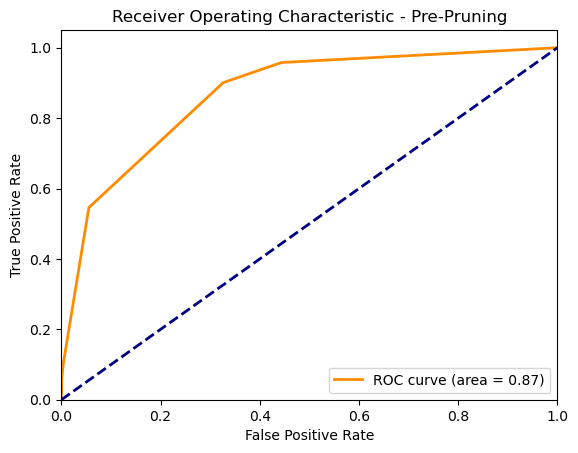

In [97]:
### 1. Pre-Pruning (Early Stopping) ###
pre_pruned_tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    min_impurity_decrease=0.01
)
pre_pruned_tree.fit(X_train, y_train)
y_test_pred_pre_pruned = pre_pruned_tree.predict(X_test)
y_test_proba_pre_pruned = pre_pruned_tree.predict_proba(X_test)[:, 1]

# Evaluate Pre-Pruned Model
accuracy_pre_pruned = accuracy_score(y_test, y_test_pred_pre_pruned)
print(f"Pre-Pruning - Accuracy: {accuracy_pre_pruned}")
print("Pre-Pruning - Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_pre_pruned))
print("Pre-Pruning - Classification Report:\n", classification_report(y_test, y_test_pred_pre_pruned))

# Plot Confusion Matrix for Pre-Pruned Model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_pre_pruned), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Pre-Pruning')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC Curve for Pre-Pruned Model
fpr_pre, tpr_pre, _ = roc_curve(y_test, y_test_proba_pre_pruned)
roc_auc_pre = auc(fpr_pre, tpr_pre)

plt.figure()
plt.plot(fpr_pre, tpr_pre, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_pre:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Pre-Pruning')
plt.legend(loc="lower right")
plt.show()

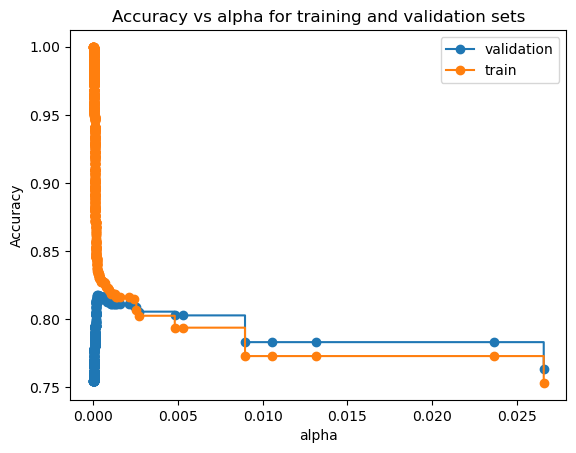

Best ccp_alpha based on validation set: 0.00027414365761517295


In [99]:
### 2. Post-Pruning (Reduced Error Pruning) ###
# Grow the full tree
full_tree = DecisionTreeClassifier(random_state=42)
full_tree.fit(X_train, y_train)

# Perform cost complexity pruning to simulate post-pruning
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Filter out invalid ccp_alpha values
ccp_alphas = ccp_alphas[ccp_alphas >= 0]

# Train trees with different values of ccp_alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

val_scores = [accuracy_score(y_val, clf.predict(X_val)) for clf in clfs]
train_scores = [accuracy_score(y_train, clf.predict(X_train)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, val_scores, marker='o', label="validation", drawstyle="steps-post")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.legend()
plt.show()

# Selecting the best alpha based on validation set performance
best_index = np.argmax(val_scores)
best_alpha = ccp_alphas[best_index]
best_pruned_tree = clfs[best_index]

print(f"Best ccp_alpha based on validation set: {best_alpha}")

# Initialize and train the pruned tree with the best alpha value
clf_pruned = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha).fit(X_train, y_train)
y_test_pred_post_pruned = clf_pruned.predict(X_test)
y_test_proba_post_pruned = clf_pruned.predict_proba(X_test)[:, 1]

Post-Pruning - Accuracy: 0.8331622176591376
Post-Pruning - Confusion Matrix:
 [[2380  564]
 [ 411 2489]]
Post-Pruning - Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      2944
           1       0.82      0.86      0.84      2900

    accuracy                           0.83      5844
   macro avg       0.83      0.83      0.83      5844
weighted avg       0.83      0.83      0.83      5844



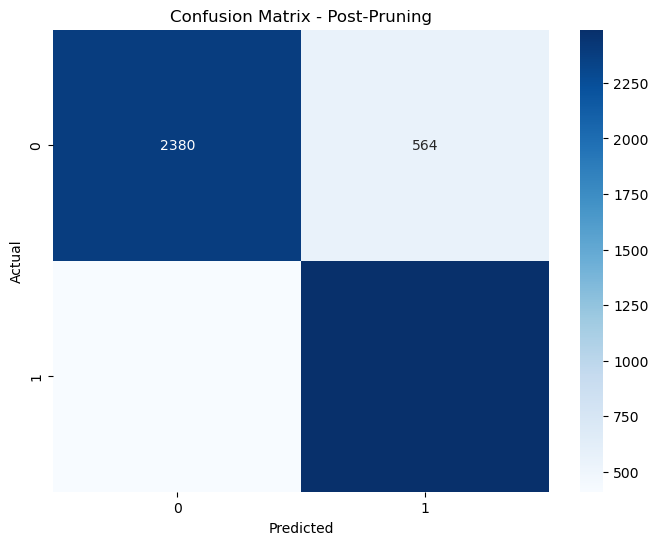

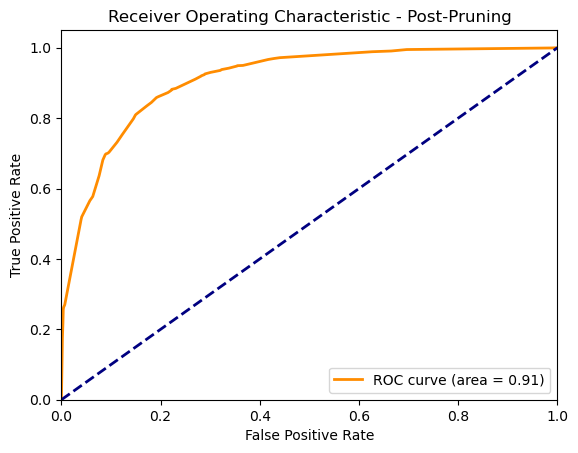

In [100]:
# Evaluate Post-Pruned Model
accuracy_post_pruned = accuracy_score(y_test, y_test_pred_post_pruned)
print(f"Post-Pruning - Accuracy: {accuracy_post_pruned}")
print("Post-Pruning - Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_post_pruned))
print("Post-Pruning - Classification Report:\n", classification_report(y_test, y_test_pred_post_pruned))

# Plot Confusion Matrix for Post-Pruned Model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_post_pruned), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Post-Pruning')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC Curve for Post-Pruned Model
fpr_post, tpr_post, _ = roc_curve(y_test, y_test_proba_post_pruned)
roc_auc_post = auc(fpr_post, tpr_post)

plt.figure()
plt.plot(fpr_post, tpr_post, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_post:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Post-Pruning')
plt.legend(loc="lower right")
plt.show()

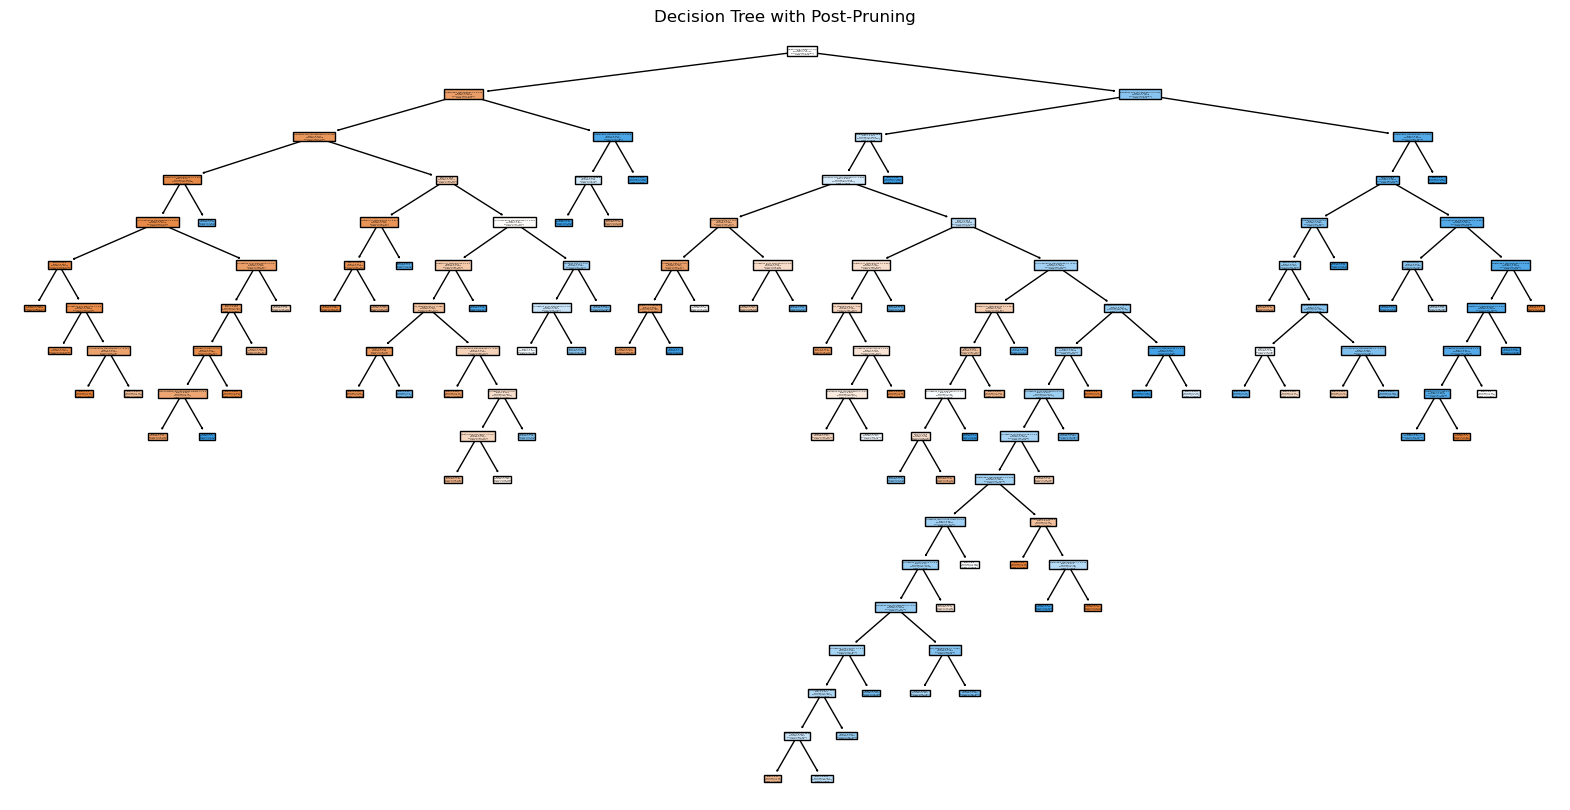

In [101]:
# Visualize the post-pruned tree
plt.figure(figsize=(20, 10))
plot_tree(clf_pruned, filled=True, feature_names=X.columns, class_names=['<=50K', '>50K'])
plt.title("Decision Tree with Post-Pruning")
plt.show()

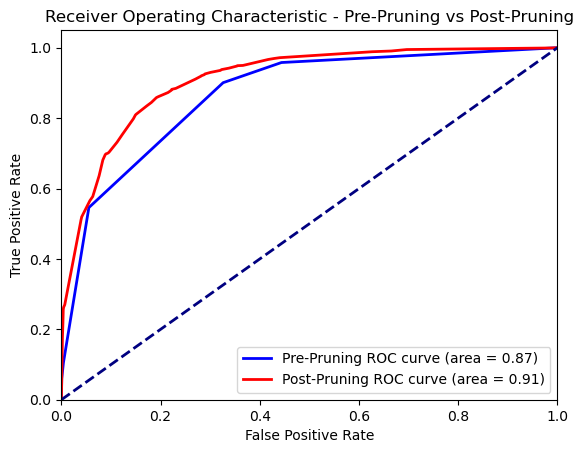

In [102]:
### Combined ROC Curves ###
plt.figure()
plt.plot(fpr_pre, tpr_pre, color='blue', lw=2, label=f'Pre-Pruning ROC curve (area = {roc_auc_pre:0.2f})')
plt.plot(fpr_post, tpr_post, color='red', lw=2, label=f'Post-Pruning ROC curve (area = {roc_auc_post:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Pre-Pruning vs Post-Pruning')
plt.legend(loc="lower right")
plt.show()

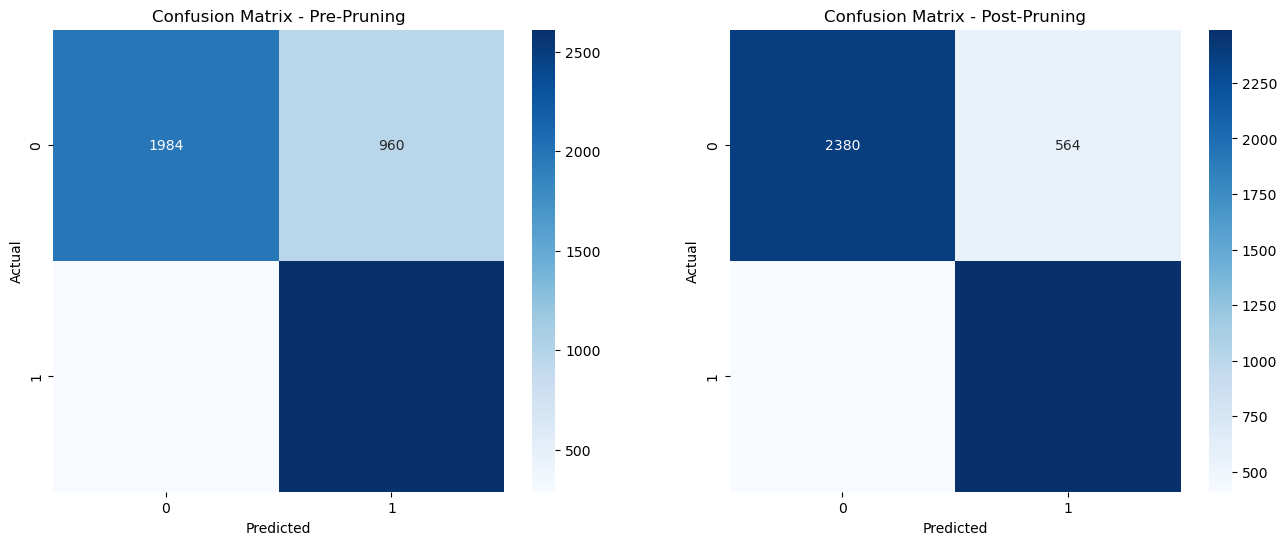

Pre-Pruning - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.67      0.76      2944
           1       0.73      0.90      0.81      2900

    accuracy                           0.79      5844
   macro avg       0.80      0.79      0.78      5844
weighted avg       0.80      0.79      0.78      5844

Post-Pruning - Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      2944
           1       0.82      0.86      0.84      2900

    accuracy                           0.83      5844
   macro avg       0.83      0.83      0.83      5844
weighted avg       0.83      0.83      0.83      5844



In [103]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


# Plot Confusion Matrices side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pre-Pruning Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred_pre_pruned), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Pre-Pruning')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Post-Pruning Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred_post_pruned), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Post-Pruning')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

# Additionally, print the classification reports for both models
print("Pre-Pruning - Classification Report:\n", classification_report(y_test, y_test_pred_pre_pruned))
print("Post-Pruning - Classification Report:\n", classification_report(y_test, y_test_pred_post_pruned))

## GridSearchCV

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Direct download URL for the Google Drive file
CSV_URL = 'https://drive.google.com/uc?export=download&id=1K2zmMuv0mj-vTdVmL7skUD_uFND0gg0U'

try:
    # Read the CSV file directly into a DataFrame
    df1 = pd.read_csv(CSV_URL)
except Exception as e:
    print("Error reading the CSV file:", e)

# Scale the 'fnlwgt' column
scaler = StandardScaler()
df1['fnlwgt'] = scaler.fit_transform(df1[['fnlwgt']])

X = df1.drop(['income'], axis=1)  # Features
y = df1['income']  # Target

# Split the dataset into training (75%), validation (25% of train), and testing sets (25%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Best estimator from GridSearchCV
best_clf = grid_search.best_estimator_

# Predictions on the test set
y_test_pred = best_clf.predict(X_test)
y_test_proba = best_clf.predict_proba(X_test)[:, 1]


/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/meenusathyanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 

Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2}
Test Set Accuracy: 0.8264887063655031
Confusion Matrix:
 [[2394  550]
 [ 464 2436]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      2944
           1       0.82      0.84      0.83      2900

    accuracy                           0.83      5844
   macro avg       0.83      0.83      0.83      5844
weighted avg       0.83      0.83      0.83      5844



In [114]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {accuracy}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Test Set Accuracy: 0.8264887063655031
Confusion Matrix:
 [[2394  550]
 [ 464 2436]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      2944
           1       0.82      0.84      0.83      2900

    accuracy                           0.83      5844
   macro avg       0.83      0.83      0.83      5844
weighted avg       0.83      0.83      0.83      5844



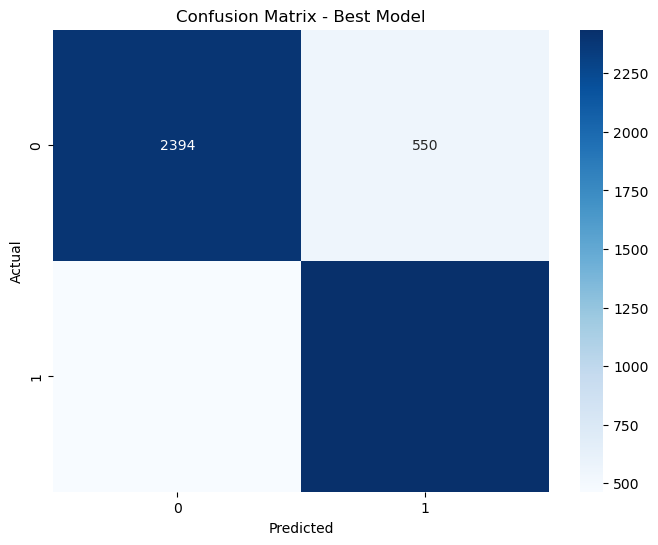

In [115]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

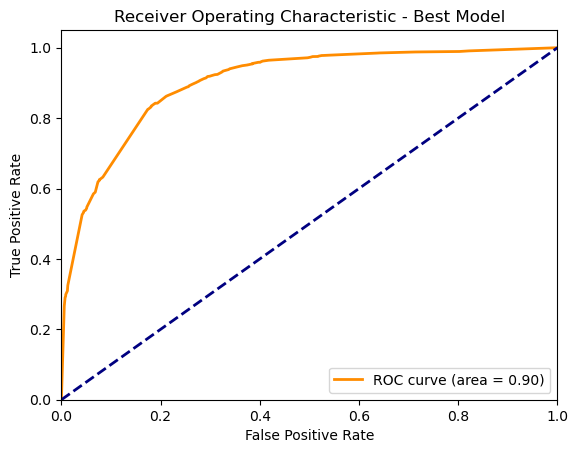

In [116]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Best Model')
plt.legend(loc="lower right")
plt.show()

# K-Fold cross validation

In [117]:
# Initialize the KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(dt_clf, X_train, y_train, cv=kf, scoring='accuracy')

# Fit the model on the full training data
dt_clf.fit(X_train, y_train)

# Predict the response for the test dataset
y_test_pred = dt_clf.predict(X_test)
y_test_proba = dt_clf.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {accuracy}")
print(f"10-Fold Cross-Validated Accuracy: {cv_scores.mean()}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))



Test Set Accuracy: 0.7717316906228611
10-Fold Cross-Validated Accuracy: 0.7665635362952932
Confusion Matrix:
 [[2285  659]
 [ 675 2225]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77      2944
           1       0.77      0.77      0.77      2900

    accuracy                           0.77      5844
   macro avg       0.77      0.77      0.77      5844
weighted avg       0.77      0.77      0.77      5844



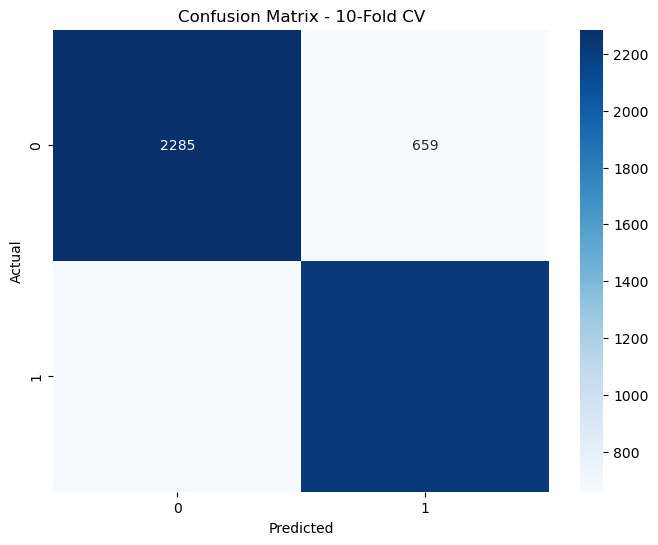

In [118]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - 10-Fold CV')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

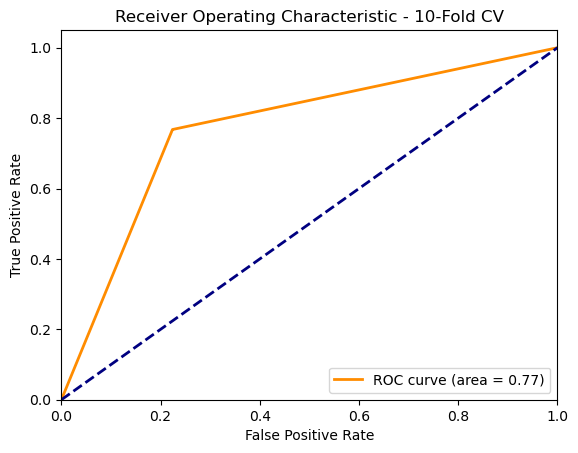

In [119]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - 10-Fold CV')
plt.legend(loc="lower right")
plt.show()

### Model Performance Comparison

| Metric/Model           | Pre-Pruning | Post-Pruning | GridSearchCV | 10-Fold CV |
|------------------------|-------------|--------------|--------------|------------|
| ROC Area               | 0.87        | 0.91         | 0.90         | 0.77       |
| Accuracy               | 0.79        | 0.83         | 0.83         | 0.77       |
| Precision (Class 0)    | 0.87        | 0.85         | 0.84         | 0.77       |
| Precision (Class 1)    | 0.73        | 0.82         | 0.82         | 0.77       |
| Recall (Class 0)       | 0.67        | 0.81         | 0.81         | 0.78       |
| Recall (Class 1)       | 0.90        | 0.86         | 0.84         | 0.77       |
| F1-Score (Class 0)     | 0.76        | 0.83         | 0.83         | 0.77       |
| F1-Score (Class 1)     | 0.81        | 0.84         | 0.83         | 0.77       |


## Conclusion
Best Model: Post-Pruning, due to its highest ROC area and accuracy, along with balanced precision, recall, and F1-score for both classes.

Post-Pruning is the best model as it provides the highest ROC area and accuracy, indicating better performance in both classification accuracy and distinguishing between classes.